# Swin Transformer

参考：https://meditech-ai.com/pytorch-swin-transformer/

In [1]:
!pip install timm

In [1]:
from __future__ import print_function

import glob
import os
import random
import cv2
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from pathlib import Path
import seaborn as sns
import timm
from pprint import pprint
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

/home/kurita/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/kurita/anaconda3/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# Training settings
epochs = 100
lr = 0.0001

In [3]:
device = 'cuda'
train_dataset_dir = Path('./data/Gender01/train')
val_dataset_dir = Path('./data/Gender01/validation')
test_dataset_dir = Path('./data/Gender01/test')

['./data/Gender01/test/female/JPCNN058.png', './data/Gender01/test/female/JPCNN059.png', './data/Gender01/test/female/JPCNN062.png', './data/Gender01/test/female/JPCNN064.png', './data/Gender01/test/female/JPCNN066.png', './data/Gender01/test/female/JPCNN067.png', './data/Gender01/test/female/JPCNN069.png', './data/Gender01/test/female/JPCNN070.png', './data/Gender01/test/female/JPCNN071.png', './data/Gender01/test/female/JPCNN073.png', './data/Gender01/test/female/JPCNN074.png', './data/Gender01/test/female/JPCNN077.png', './data/Gender01/test/female/JPCNN078.png', './data/Gender01/test/female/JPCNN080.png', './data/Gender01/test/female/JPCNN081.png', './data/Gender01/test/female/JPCNN083.png', './data/Gender01/test/female/JPCNN084.png', './data/Gender01/test/female/JPCNN085.png', './data/Gender01/test/female/JPCNN087.png', './data/Gender01/test/female/JPCNN090.png', './data/Gender01/test/female/JPCNN092.png', './data/Gender01/test/male/JPCNN044.png', './data/Gender01/test/male/JPCNN0

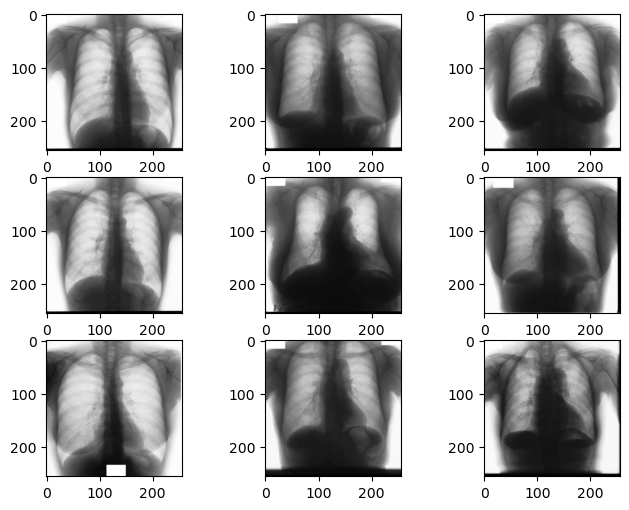

In [4]:
files = glob.glob('./data/Gender01/*/*/*.png')
print(files)
random_idx = np.random.randint(1, len(files), size=9)
fig, axes = plt.subplots(3, 3, figsize=(8, 6))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(files[idx])
    ax.imshow(img,  cmap='Greys')

In [6]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

In [7]:
train_data = datasets.ImageFolder(train_dataset_dir,train_transforms)
valid_data = datasets.ImageFolder(val_dataset_dir, val_transforms)
test_data = datasets.ImageFolder(test_dataset_dir, test_transforms)

In [8]:
train_loader = DataLoader(dataset = train_data, batch_size=16, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=16, shuffle=False)
test_loader = DataLoader(dataset = test_data, batch_size=16, shuffle=False)

In [9]:
model_names = timm.list_models(pretrained=True)
pprint(model_names)

['bat_resnext26ts.ch_in1k',
 'beit_base_patch16_224.in22k_ft_in22k',
 'beit_base_patch16_224.in22k_ft_in22k_in1k',
 'beit_base_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_224.in22k_ft_in22k',
 'beit_large_patch16_224.in22k_ft_in22k_in1k',
 'beit_large_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_512.in22k_ft_in22k_in1k',
 'beitv2_base_patch16_224.in1k_ft_in1k',
 'beitv2_base_patch16_224.in1k_ft_in22k',
 'beitv2_base_patch16_224.in1k_ft_in22k_in1k',
 'beitv2_large_patch16_224.in1k_ft_in1k',
 'beitv2_large_patch16_224.in1k_ft_in22k',
 'beitv2_large_patch16_224.in1k_ft_in22k_in1k',
 'botnet26t_256.c1_in1k',
 'caformer_b36.sail_in1k',
 'caformer_b36.sail_in1k_384',
 'caformer_b36.sail_in22k',
 'caformer_b36.sail_in22k_ft_in1k',
 'caformer_b36.sail_in22k_ft_in1k_384',
 'caformer_m36.sail_in1k',
 'caformer_m36.sail_in1k_384',
 'caformer_m36.sail_in22k',
 'caformer_m36.sail_in22k_ft_in1k',
 'caformer_m36.sail_in22k_ft_in1k_384',
 'caformer_s18.sail_in1k',
 'caformer_s18.s

In [10]:
model = timm.create_model('swin_base_patch4_window7_224.ms_in22k', pretrained=True, num_classes=2)
model = model.to(device)

### Fine Tuning for Medical Data

In [11]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

In [12]:
best_loss = None

# Accuracy計算用の関数
def calculate_accuracy(output, target):
    output = (torch.sigmoid(output) >= 0.5)
    target = (target == 1.0)
    accuracy = torch.true_divide((target == output).sum(dim=0), output.size(0)).item()
    return accuracy

train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)              

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

    train_acc_list.append(epoch_accuracy)
    val_acc_list.append(epoch_val_accuracy)
    train_loss_list.append(epoch_loss)
    val_loss_list.append(epoch_val_loss)

    if (best_loss is None) or (best_loss > val_loss):
        best_loss = val_loss
        model_path = './trained_models/bestswinmodel.pth'
        torch.save(model.state_dict(), model_path)
        
    print()

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.8748 - acc: 0.4988 - val_loss : 0.6836 - val_acc: 0.5089




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.5820 - acc: 0.7013 - val_loss : 0.7941 - val_acc: 0.4375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.3260 - acc: 0.8500 - val_loss : 0.3370 - val_acc: 0.8542




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.1649 - acc: 0.9563 - val_loss : 0.4383 - val_acc: 0.8958




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.1396 - acc: 0.9463 - val_loss : 0.3833 - val_acc: 0.9167




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.0941 - acc: 0.9625 - val_loss : 0.4316 - val_acc: 0.8750




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.1187 - acc: 0.9688 - val_loss : 0.5561 - val_acc: 0.8006




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.0500 - acc: 0.9750 - val_loss : 0.5803 - val_acc: 0.8750




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.0194 - acc: 0.9938 - val_loss : 0.4677 - val_acc: 0.8958




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.0019 - acc: 1.0000 - val_loss : 0.5225 - val_acc: 0.8958




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.0004 - acc: 1.0000 - val_loss : 0.4842 - val_acc: 0.8958




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.0005 - acc: 1.0000 - val_loss : 0.5446 - val_acc: 0.8542




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.0011 - acc: 1.0000 - val_loss : 0.5717 - val_acc: 0.8958




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.0088 - acc: 0.9900 - val_loss : 0.6571 - val_acc: 0.8958




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.0608 - acc: 0.9625 - val_loss : 0.6545 - val_acc: 0.8482




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.0819 - acc: 0.9688 - val_loss : 0.9219 - val_acc: 0.6875




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.1057 - acc: 0.9625 - val_loss : 0.3263 - val_acc: 0.9167




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.0418 - acc: 0.9875 - val_loss : 0.4795 - val_acc: 0.9167




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.0015 - acc: 1.0000 - val_loss : 0.8161 - val_acc: 0.8958




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.0100 - acc: 0.9938 - val_loss : 0.7524 - val_acc: 0.8958




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 21 - loss : 0.0234 - acc: 0.9938 - val_loss : 1.1530 - val_acc: 0.8214




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 22 - loss : 0.0832 - acc: 0.9813 - val_loss : 0.3673 - val_acc: 0.9167




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 23 - loss : 0.0527 - acc: 0.9875 - val_loss : 0.4505 - val_acc: 0.8958




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 24 - loss : 0.0191 - acc: 1.0000 - val_loss : 0.4534 - val_acc: 0.8958




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 25 - loss : 0.0197 - acc: 0.9938 - val_loss : 0.6608 - val_acc: 0.8750




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 26 - loss : 0.0183 - acc: 0.9938 - val_loss : 0.5427 - val_acc: 0.9167




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 27 - loss : 0.0142 - acc: 0.9938 - val_loss : 0.4973 - val_acc: 0.9375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 28 - loss : 0.0010 - acc: 1.0000 - val_loss : 0.5564 - val_acc: 0.8750




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 29 - loss : 0.0010 - acc: 1.0000 - val_loss : 0.4479 - val_acc: 0.9167




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 30 - loss : 0.0009 - acc: 1.0000 - val_loss : 0.5968 - val_acc: 0.9167




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 31 - loss : 0.0003 - acc: 1.0000 - val_loss : 0.5874 - val_acc: 0.8958




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 32 - loss : 0.0002 - acc: 1.0000 - val_loss : 0.5700 - val_acc: 0.9375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 33 - loss : 0.0002 - acc: 1.0000 - val_loss : 0.6049 - val_acc: 0.9375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 34 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.5682 - val_acc: 0.9375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 35 - loss : 0.0002 - acc: 1.0000 - val_loss : 0.6159 - val_acc: 0.9375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 36 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.5986 - val_acc: 0.9167




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 37 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.6263 - val_acc: 0.9167




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 38 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.6500 - val_acc: 0.9167




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 39 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.6225 - val_acc: 0.9167




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 40 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.6816 - val_acc: 0.9375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 41 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.6823 - val_acc: 0.9375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 42 - loss : 0.0019 - acc: 1.0000 - val_loss : 0.6742 - val_acc: 0.9167




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 43 - loss : 0.0002 - acc: 1.0000 - val_loss : 0.7515 - val_acc: 0.8958




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 44 - loss : 0.0004 - acc: 1.0000 - val_loss : 0.8516 - val_acc: 0.8750




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 45 - loss : 0.0003 - acc: 1.0000 - val_loss : 0.7609 - val_acc: 0.8958




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 46 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.7746 - val_acc: 0.8958




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 47 - loss : 0.0035 - acc: 1.0000 - val_loss : 0.7385 - val_acc: 0.9375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 48 - loss : 0.0074 - acc: 0.9938 - val_loss : 0.8910 - val_acc: 0.8958




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 49 - loss : 0.0043 - acc: 1.0000 - val_loss : 0.7929 - val_acc: 0.9167




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 50 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.7894 - val_acc: 0.8958




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 51 - loss : 0.0057 - acc: 1.0000 - val_loss : 0.8147 - val_acc: 0.9167




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 52 - loss : 0.0085 - acc: 0.9938 - val_loss : 0.6703 - val_acc: 0.9167




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 53 - loss : 0.0002 - acc: 1.0000 - val_loss : 0.6853 - val_acc: 0.8958




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 54 - loss : 0.0023 - acc: 1.0000 - val_loss : 0.5049 - val_acc: 0.9167




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 55 - loss : 0.0039 - acc: 1.0000 - val_loss : 0.7157 - val_acc: 0.8958




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 56 - loss : 0.0023 - acc: 1.0000 - val_loss : 0.6900 - val_acc: 0.9167




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 57 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.6218 - val_acc: 0.9375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 58 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.6622 - val_acc: 0.9167




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 59 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.6361 - val_acc: 0.9375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 60 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.6932 - val_acc: 0.9167




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 61 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.6306 - val_acc: 0.9375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 62 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.7070 - val_acc: 0.9375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 63 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.6681 - val_acc: 0.9375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 64 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.6463 - val_acc: 0.9167




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 65 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.6984 - val_acc: 0.9375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 66 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.6491 - val_acc: 0.9167




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 67 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.6942 - val_acc: 0.9375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 68 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.5835 - val_acc: 0.9375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 69 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.6656 - val_acc: 0.9375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 70 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.6816 - val_acc: 0.9375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 71 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.7072 - val_acc: 0.9375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 72 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.5894 - val_acc: 0.9375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 73 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.6523 - val_acc: 0.9167




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 74 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.6563 - val_acc: 0.9375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 75 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.6594 - val_acc: 0.9375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 76 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.6648 - val_acc: 0.9375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 77 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.6974 - val_acc: 0.9375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 78 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.7050 - val_acc: 0.9375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 79 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.7279 - val_acc: 0.9375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 80 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.6242 - val_acc: 0.9375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 81 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.7050 - val_acc: 0.9167




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 82 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.7353 - val_acc: 0.9167




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 83 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.7771 - val_acc: 0.8958




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 84 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.7662 - val_acc: 0.9375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 85 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.6915 - val_acc: 0.9375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 86 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.6900 - val_acc: 0.9375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 87 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.7315 - val_acc: 0.9375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 88 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.6838 - val_acc: 0.9375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 89 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.7618 - val_acc: 0.9375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 90 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.7169 - val_acc: 0.9167




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 91 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.7574 - val_acc: 0.8958




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 92 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.7091 - val_acc: 0.9375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 93 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.7031 - val_acc: 0.9375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 94 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.7427 - val_acc: 0.9375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 95 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.7505 - val_acc: 0.8958




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 96 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.7778 - val_acc: 0.9167




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 97 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.6445 - val_acc: 0.9375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 98 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.7208 - val_acc: 0.9375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 99 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.7334 - val_acc: 0.9375




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 100 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.7200 - val_acc: 0.9375




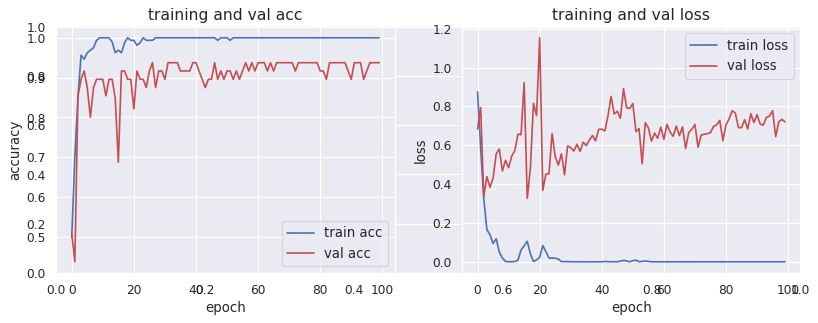

In [13]:
device2 = torch.device('cpu')

train_acc = []
train_loss = []
val_acc = []
val_loss = []

for i in range(epochs):
    train_acc2 = train_acc_list[i].to(device2)
    train_acc3 = train_acc2.clone().numpy()
    train_acc.append(train_acc3)
    
    train_loss2 = train_loss_list[i].to(device2)
    train_loss3 = train_loss2.clone().detach().numpy()
    train_loss.append(train_loss3)
    
    val_acc2 = val_acc_list[i].to(device2)
    val_acc3 = val_acc2.clone().numpy()
    val_acc.append(val_acc3)
    
    val_loss2 = val_loss_list[i].to(device2)
    val_loss3 = val_loss2.clone().numpy()
    val_loss.append(val_loss3)

#取得したデータをグラフ化する
sns.set()
num_epochs = epochs

fig = plt.subplots(figsize=(12, 4), dpi=80)

ax1 = plt.subplot(1,2,1)
ax1.plot(range(num_epochs), train_acc, c='b', label='train acc')
ax1.plot(range(num_epochs), val_acc, c='r', label='val acc')
ax1.set_xlabel('epoch', fontsize='12')
ax1.set_ylabel('accuracy', fontsize='12')
ax1.set_title('training and val acc', fontsize='14')
ax1.legend(fontsize='12')

ax2 = plt.subplot(1,2,2)
ax2.plot(range(num_epochs), train_loss, c='b', label='train loss')
ax2.plot(range(num_epochs), val_loss, c='r', label='val loss')
ax2.set_xlabel('epoch', fontsize='12')
ax2.set_ylabel('loss', fontsize='12')
ax2.set_title('training and val loss', fontsize='14')
ax2.legend(fontsize='12')
plt.show()

/tmp/ipykernel_20016/2146568538.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./trained_models/bestswinmodel.pth"))


Accuracy: 0.9362
感度: 0.9231
特異度: 0.9524
PPV: 0.9600
NPV: 0.9091
F-Score: 0.9412
AUC: 0.9487


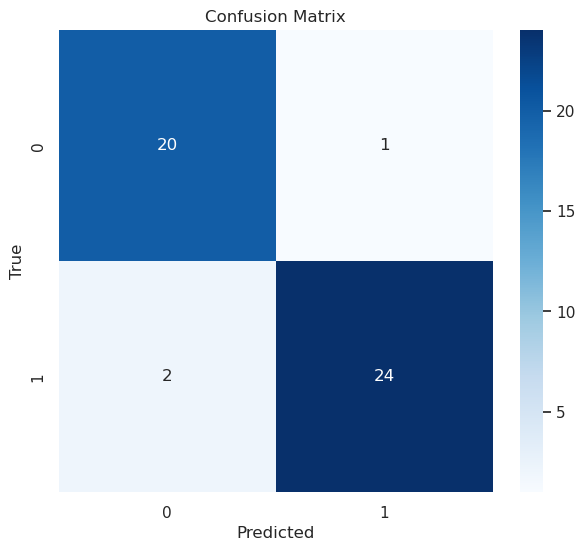

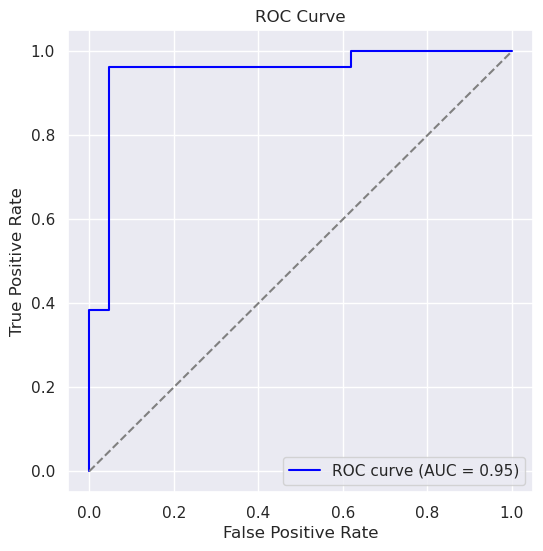

In [14]:
def evaluate_model(model, test_loader):
    model.load_state_dict(torch.load("./trained_models/bestswinmodel.pth"))
    model.eval()
    predictions = []
    actuals = []
    probas = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            probas.extend(outputs[:, 1].cpu().numpy())  # 二番目のクラス（陽性クラス）の確率
            predictions.extend(predicted.cpu().numpy())
            actuals.extend(labels.cpu().numpy())


    # 指標の計算
    confusion = confusion_matrix(actuals, predictions)
    accuracy = accuracy_score(actuals, predictions)
    recall = recall_score(actuals, predictions)  # 感度
    specificity = recall_score(actuals, predictions, pos_label=0)
    precision = precision_score(actuals, predictions)  # PPV
    npv = precision_score(actuals, predictions, pos_label=0)  # NPV
    f1 = f1_score(actuals, predictions)
    auc = roc_auc_score(actuals, probas)


    #print("混同行列:\n", confusion)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"感度: {recall:.4f}")
    print(f"特異度: {specificity:.4f}")
    print(f"PPV: {precision:.4f}")
    print(f"NPV: {npv:.4f}")
    print(f"F-Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")


    # Confusion matrixの描画
    # 混同行列の可視化
    plt.figure(figsize=(7, 6))
    sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()


    # ROC曲線の描画
    fpr, tpr, thresholds = roc_curve(actuals, probas)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()


evaluate_model(model, test_loader)